# Climate Analysis

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
engine = create_engine("sqlite:///hawaiidb.sqlite", echo=False)

In [4]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['Measurement', 'Station']

In [5]:
Measurement = Base.classes.Measurement
# Measurement.__table__

In [6]:
Station = Base.classes.Station
#Station.__table__

In [7]:
session = Session(engine)

# Precipitation Analysis

In [8]:
df = pd.DataFrame(session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all())
df.head()


,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65.0
1,USC00519397,2010-01-02,0.00,63.0
2,USC00519397,2010-01-03,0.00,74.0
3,USC00519397,2010-01-04,0.00,76.0
4,USC00519397,2010-01-07,0.06,70.0


In [37]:
percipitation = df[(df.date >= '2016-01-01') & (df.date <= '2016-12-31')].groupby(['date']).sum()
percipitation.drop('tobs',inplace=True, axis=1)
percipitation.sort_index()
percipitation.head()

,prcp
date,
2016-01-01,0.04
2016-01-02,0.35
2016-01-03,0.00
2016-01-04,0.00
2016-01-05,0.47


In [38]:
x_axis = np.arange(len(percipitation.prcp))
x_lbls = [value for idx, value in enumerate(percipitation.index) if idx % 30 == 0]


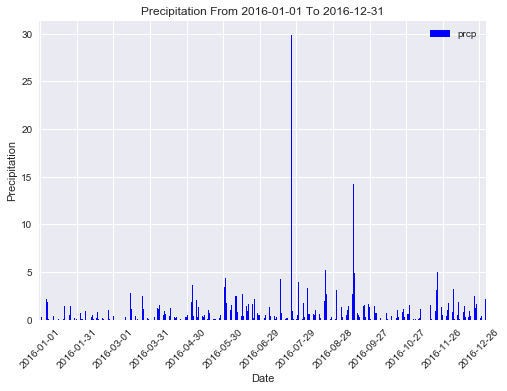

In [39]:
percipitation.plot.bar(color = 'blue')
tick_locations = [value + 0.1 for idx, value in enumerate(x_axis) if idx % 30 == 0]
plt.xticks(tick_locations, x_lbls, rotation=45)
plt.title("Precipitation From " + percipitation.index[0] + " To " + percipitation.index[-1])
plt.xlabel("Date")
plt.ylabel("Precipitation")
sns.set()
plt.savefig('precipitation.png')
plt.show()

# Station Analysis

* Design a query to calculate the total number of stations.
* Design a query to find the most active stations.
* List the stations and observation counts in descending order
* Which station has the highest number of observations?
* Design a query to retrieve the last 12 months of temperature observation data (tobs).
* Filter by the station with the highest number of observations.
* Plot the results as a histogram with bins=12.

In [40]:
# Design a query to calculate the total number of stations.
### BEGIN SOLUTION
from sqlalchemy import func, distinct
sel = [func.count(distinct(Measurement.station))]
   
results = session.query(*sel).scalar()

print(results)

9


In [41]:
# Design a query to find the most active stations.
### BEGIN SOLUTION
from sqlalchemy import func
sel = [Measurement.station, func.count(Measurement.station)]
   
results = session.query(*sel).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
        
print(results)

[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]


('USC00519281', 2772) The Station with highest Observation

In [47]:
# Design a query to retrieve the last 12 months of tobs data.
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year 
# (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
### BEGIN SOLUTION
from sqlalchemy import func
sel = [Measurement.station, Measurement.tobs]
    
results_tobs = session.query(*sel).\
        filter(Measurement.date.between('2015-01-01','2015-12-31')).\
        filter(Measurement.station == 'USC00519281').\
       order_by(Measurement.date.asc()).all()
print(results_tobs[:5])

[('USC00519281', 74.0), ('USC00519281', 72.0), ('USC00519281', 68.0), ('USC00519281', 69.0), ('USC00519281', 70.0)]


In [48]:
#unpack the tuples
temp = [i[1] for i in results_tobs]
temp[:5]

[74.0, 72.0, 68.0, 69.0, 70.0]

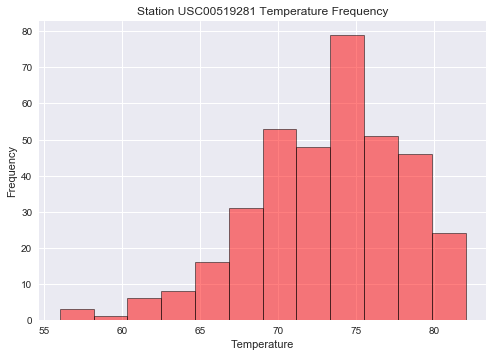

In [49]:
# plt.hist(temp,bins=12,color='coral')
# plt.show()

plt.hist(temp, bins=12, alpha=0.5, edgecolor='black', linewidth='1',color='red')
plt.title("Station " + "USC00519281" + " Temperature Frequency")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
sns.set()
plt.savefig('temperature.png')
plt.show()

# Temperature Analysis

In [50]:
from sqlalchemy import func
def calc_temps(start_date,end_date):
    sel = [func.max(Measurement.tobs),func.avg(Measurement.tobs),func.min(Measurement.tobs)]
    temp_calculation = session.query(*sel).\
        filter(Measurement.date.between(start_date,end_date)).\
        order_by(Measurement.date.asc()).one()
    
    return temp_calculation

In [51]:
tmin, tmax, tmean = calc_temps('2016-01-01', '2016-12-31')
tmin, tmax, tmean

(84.0, 74.08554857419043, 56.0)

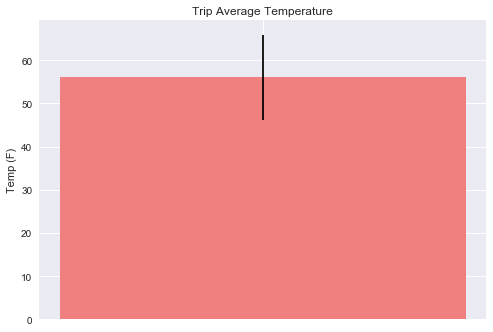

In [52]:
x = ['']
mean = [tmean]
variance = [tmax-tmin]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, mean, width=0.2, color='lightcoral', alpha=1, yerr=variance)
plt.ylabel("Temp (F)")
plt.title("Trip Average Temperature")

plt.xticks(x_pos, x)
sns.set()
plt.show()
plt.savefig('average_trip_temperature.png')
